In [41]:
import numpy as np
import pandas as pd
import ast
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches


In [42]:
path = '/home/dkabe/Model_brainstorming/Output/Variable_vals/'

In [43]:
Manufacturing_plants = 6
Distribution = 4
Market = 29
num_Scenarios = 128
Products = 3
Outsourced = 3
rl = [0.5, 0.95]
r_level = 0.5

In [44]:
demand = np.loadtxt('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_1/Demand_1.txt').reshape((128, 3, 29))
text_file = open('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_1/scen_1.txt', "r")
ls = text_file.read().split('\n')[:-1]
Scen = list(map(lambda x: ast.literal_eval(x), ls))
f = open(path + "Instance_1/variable_vals_" +str(r_level) + ".txt", "r")
text = f.read()
f.close()
solutions_str = text.split('\n')
for i in solutions_str:
    exec(i.lstrip().rstrip())

In [45]:
print(v_val_x_i)
print(v_val_x_j)

{0: -0.0, 1: 1.0, 2: -0.0, 3: 1.0, 4: 1.0, 5: -0.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [46]:
indices = [21, 56]
for index in indices:
    print(Scen[index])

[[1, 1, 1, 1, 0, 0], (1, 0, 1, 0)]
[[1, 1, 0, 0, 0, 0], (0, 1, 1, 1)]


/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


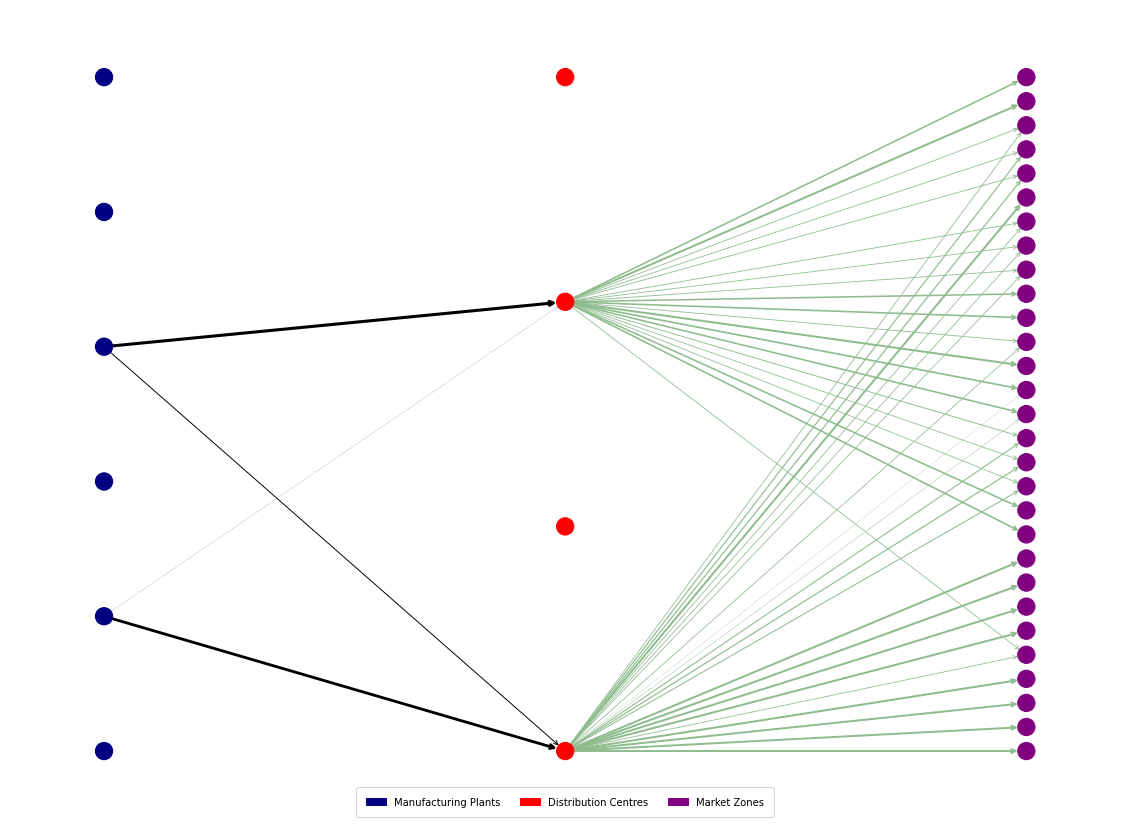

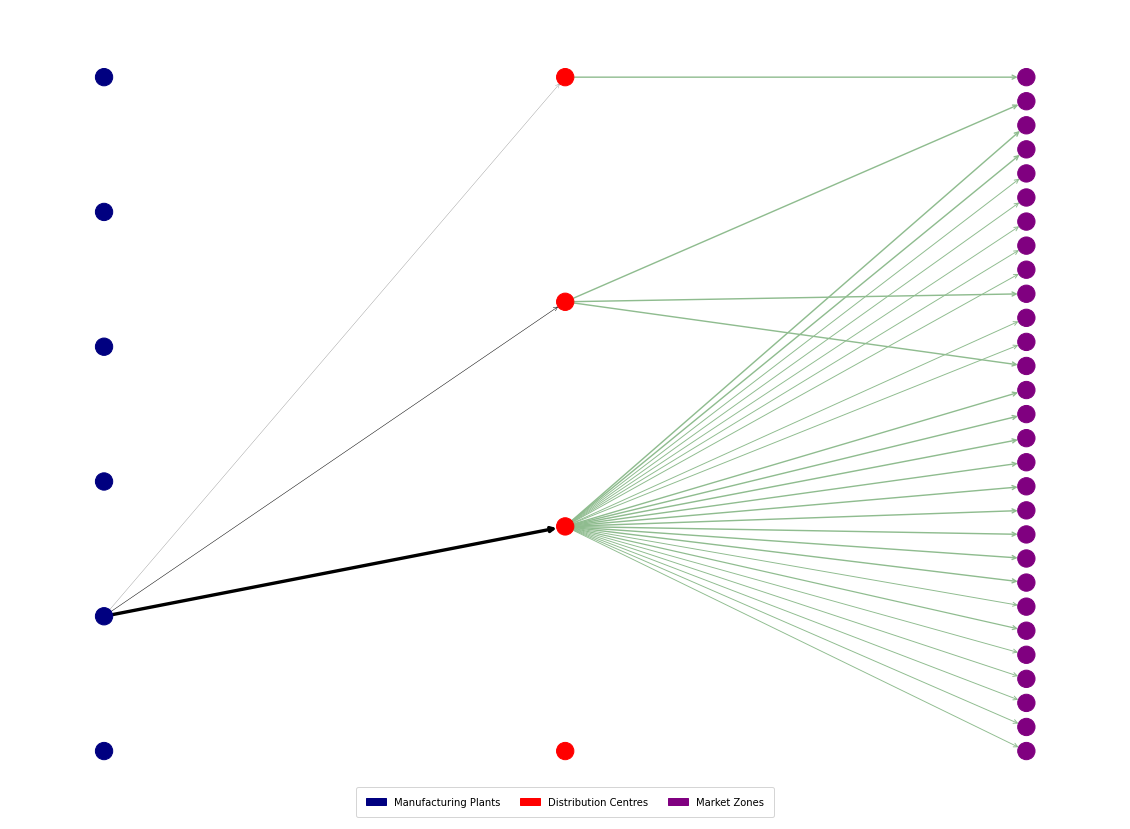

In [7]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    
    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    
    MP = ["I_" + str(i) for i in range(Manufacturing_plants)]
    DC = ["J_" + str(j) for j in range(Distribution)]
    MZ = ["K_" + str(k) for k in range(Market)]
    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market)
    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("I_" + str(i), "J_" + str(j)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("J_" + str(j), "K_" + str(k)))
    Weight_jk.extend(Z.sum(axis=1))
        
    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
                
    Labels = []
    Graph = nx.Graph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])
        Graph.add_node(MP[i])
        Node_colors.append('navy')
        Labels.append("i" + str(i))
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        Node_colors.append('red')
        Labels.append("j" + str(j))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('purple')
        Labels.append("k" + str(k))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])

    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = False, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')

    limits=plt.axis('off')
    plt.gcf().set_size_inches(20, 15)

    legend_mp = mpatches.Patch(color = 'navy', label = 'Manufacturing Plants')
    legend_dc = mpatches.Patch(color = 'red', label = 'Distribution Centres')
    legend_mz = mpatches.Patch(color = 'purple', label = 'Market Zones')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp, legend_dc, legend_mz], ncol = 3, borderpad=1)

    plt.show()

/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:131: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


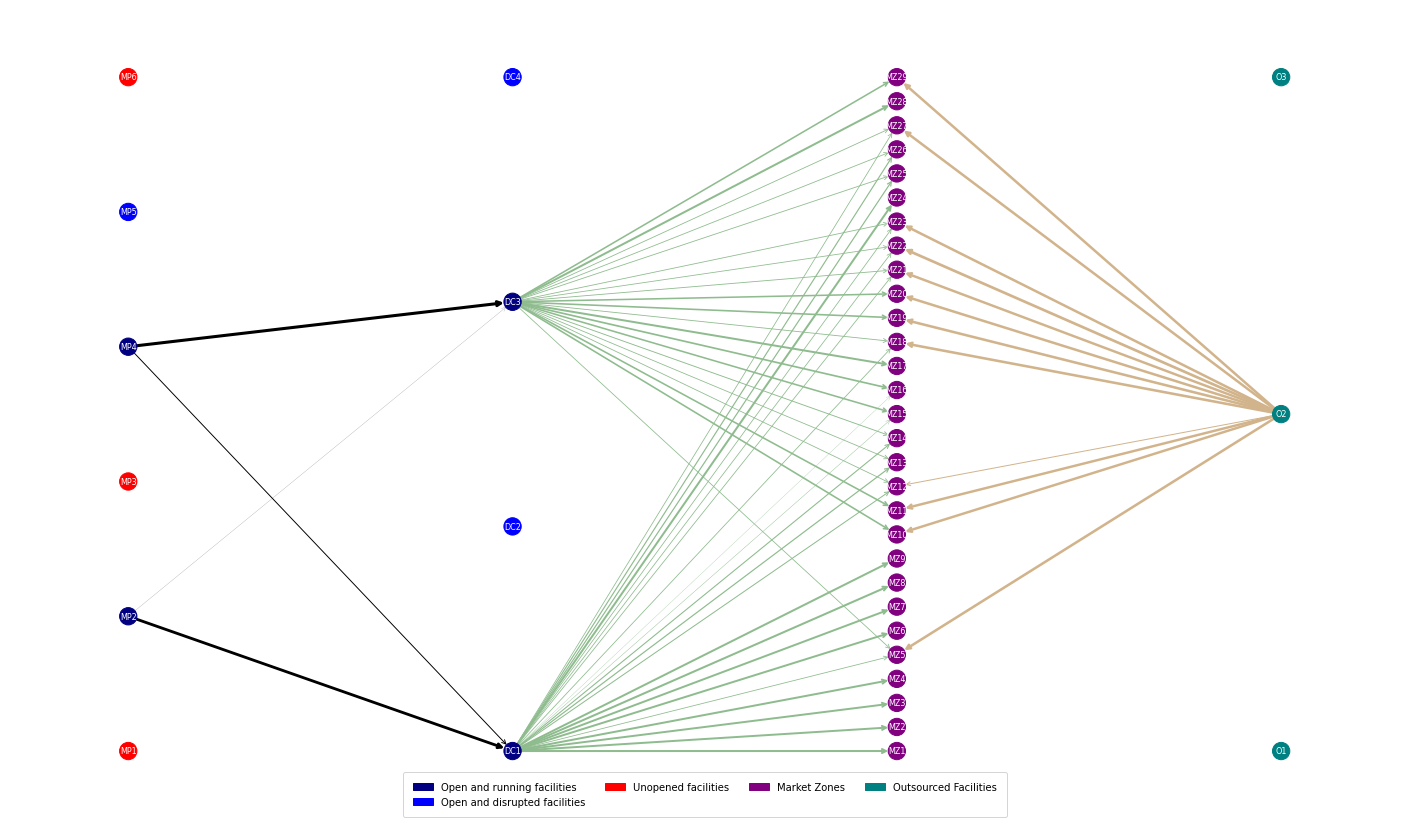

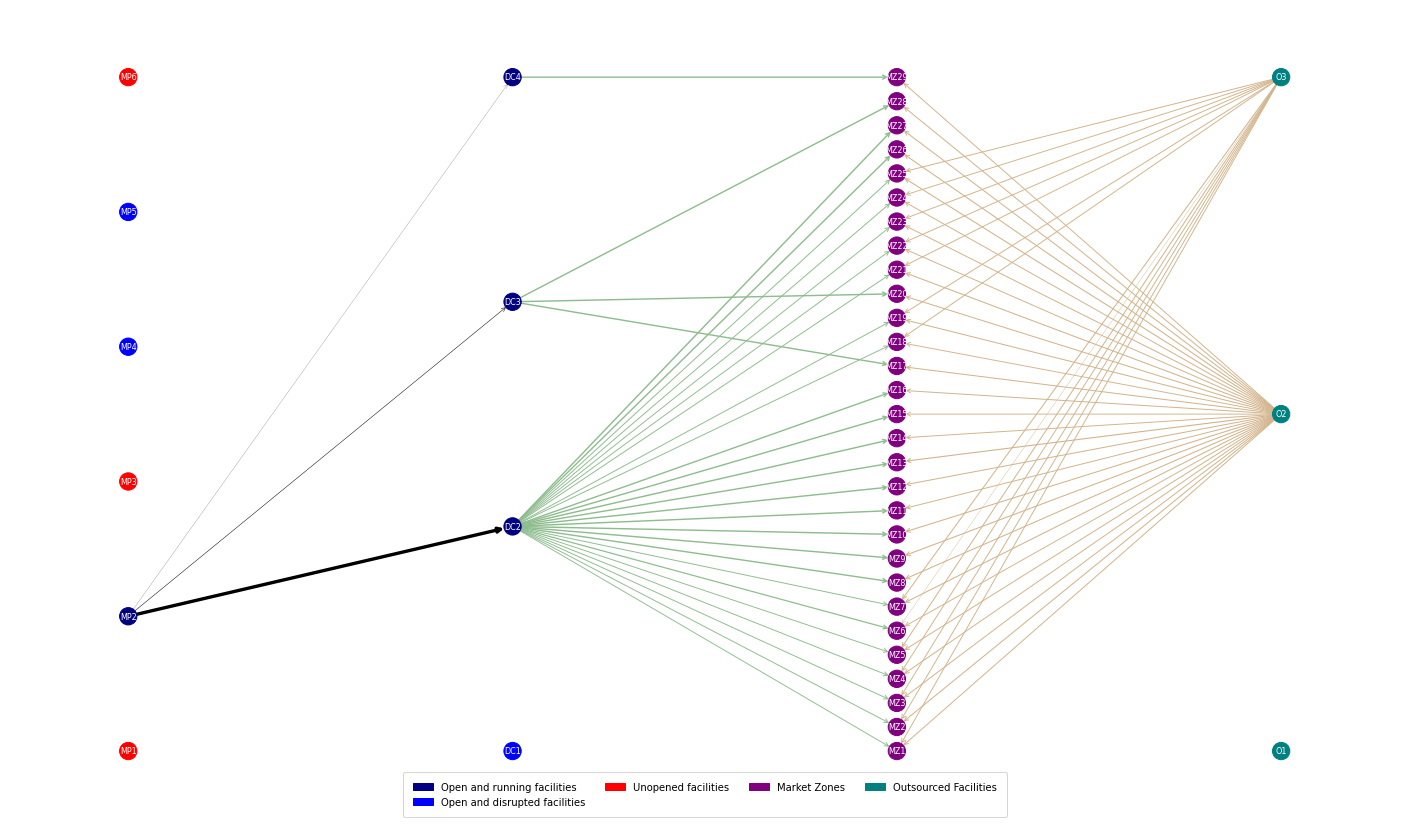

In [60]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)

    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    T2 = sum(T2_mat[index])

    MP = ["MP" + str(i+1) for i in range(Manufacturing_plants)]
    DC = ["DC" + str(j+1) for j in range(Distribution)]
    MZ = ["MZ" + str(k+1) for k in range(Market)]
    O = ["O" + str(l+1) for l in range(Outsourced)]

    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Weight_lk = []
    Max_p = max(Manufacturing_plants, Distribution, Market, Outsourced)

    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("MP" + str(i+1), "DC" + str(j+1)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("DC" + str(j+1), "MZ" + str(k+1)))
    Weight_jk.extend(Z.sum(axis=1))

    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("O" + str(l+1), "MZ" + str(k+1)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
    Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])        

                
    Labels = []
    Graph = nx.DiGraph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])        
        Graph.add_node(MP[i])
        if v_val_x_i[i] == 1 and Scen[index][0][i] == 1:
            Node_colors.append('navy')
        elif v_val_x_i[i] == 1 and Scen[index][0][i] == 0:
            Node_colors.append('blue')
        else:
            Node_colors.append("red")
        Labels.append("i" + str(i))
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        if v_val_x_j[j] == 1 and Scen[index][1][j] == 1:
            Node_colors.append('navy')
        elif v_val_x_j[j] == 1 and Scen[index][1][j] == 0:
            Node_colors.append('blue')
        else:
            Node_colors.append("red")
        Labels.append("j" + str(j))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('purple')
        Labels.append("k" + str(k))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

  
    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (3, y_pos[l])
        Graph.add_node(O[l])
        Node_colors.append('teal')
        Labels.append("l" + str(l))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(O, Position_values)))

    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Graph.add_edges_from(LK_edges)


    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])
    Edge_colors.extend(['tan' for l in LK_edges])


    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = True, font_size = 8, font_color = "white", node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight, arrows=True, arrowstyle = '->')


    limits=plt.axis('off')
    plt.gcf().set_size_inches(25, 15)

    legend_mp_1 = mpatches.Patch(color = 'navy', label = 'Open and running facilities')
    legend_mp_2 = mpatches.Patch(color = 'blue', label = 'Open and disrupted facilities')
    legend_mp_3 = mpatches.Patch(color = 'red', label = 'Unopened facilities')
    legend_mz = mpatches.Patch(color = 'purple', label = 'Market Zones')
    legend_o = mpatches.Patch(color = 'teal', label = 'Outsourced Facilities')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp_1, legend_mp_2, legend_mp_3, legend_mz, legend_o], ncol = 4, borderpad=1)

    plt.show()

In [50]:
LK_edges

[('L_0', 'K_0'),
 ('L_0', 'K_1'),
 ('L_0', 'K_2'),
 ('L_0', 'K_3'),
 ('L_0', 'K_4'),
 ('L_0', 'K_5'),
 ('L_0', 'K_6'),
 ('L_0', 'K_7'),
 ('L_0', 'K_8'),
 ('L_0', 'K_9'),
 ('L_0', 'K_10'),
 ('L_0', 'K_11'),
 ('L_0', 'K_12'),
 ('L_0', 'K_13'),
 ('L_0', 'K_14'),
 ('L_0', 'K_15'),
 ('L_0', 'K_16'),
 ('L_0', 'K_17'),
 ('L_0', 'K_18'),
 ('L_0', 'K_19'),
 ('L_0', 'K_20'),
 ('L_0', 'K_21'),
 ('L_0', 'K_22'),
 ('L_0', 'K_23'),
 ('L_0', 'K_24'),
 ('L_0', 'K_25'),
 ('L_0', 'K_26'),
 ('L_0', 'K_27'),
 ('L_0', 'K_28'),
 ('L_1', 'K_0'),
 ('L_1', 'K_1'),
 ('L_1', 'K_2'),
 ('L_1', 'K_3'),
 ('L_1', 'K_4'),
 ('L_1', 'K_5'),
 ('L_1', 'K_6'),
 ('L_1', 'K_7'),
 ('L_1', 'K_8'),
 ('L_1', 'K_9'),
 ('L_1', 'K_10'),
 ('L_1', 'K_11'),
 ('L_1', 'K_12'),
 ('L_1', 'K_13'),
 ('L_1', 'K_14'),
 ('L_1', 'K_15'),
 ('L_1', 'K_16'),
 ('L_1', 'K_17'),
 ('L_1', 'K_18'),
 ('L_1', 'K_19'),
 ('L_1', 'K_20'),
 ('L_1', 'K_21'),
 ('L_1', 'K_22'),
 ('L_1', 'K_23'),
 ('L_1', 'K_24'),
 ('L_1', 'K_25'),
 ('L_1', 'K_26'),
 ('L_1', 'K_

/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:59: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


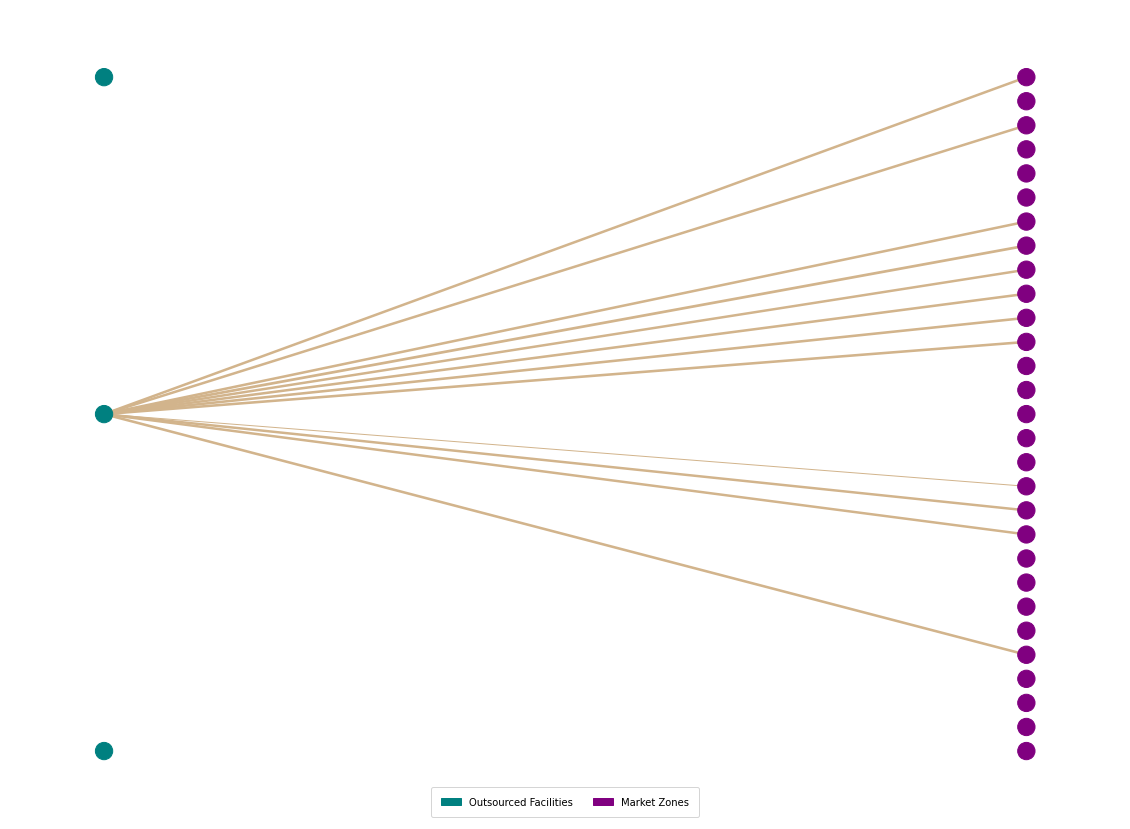

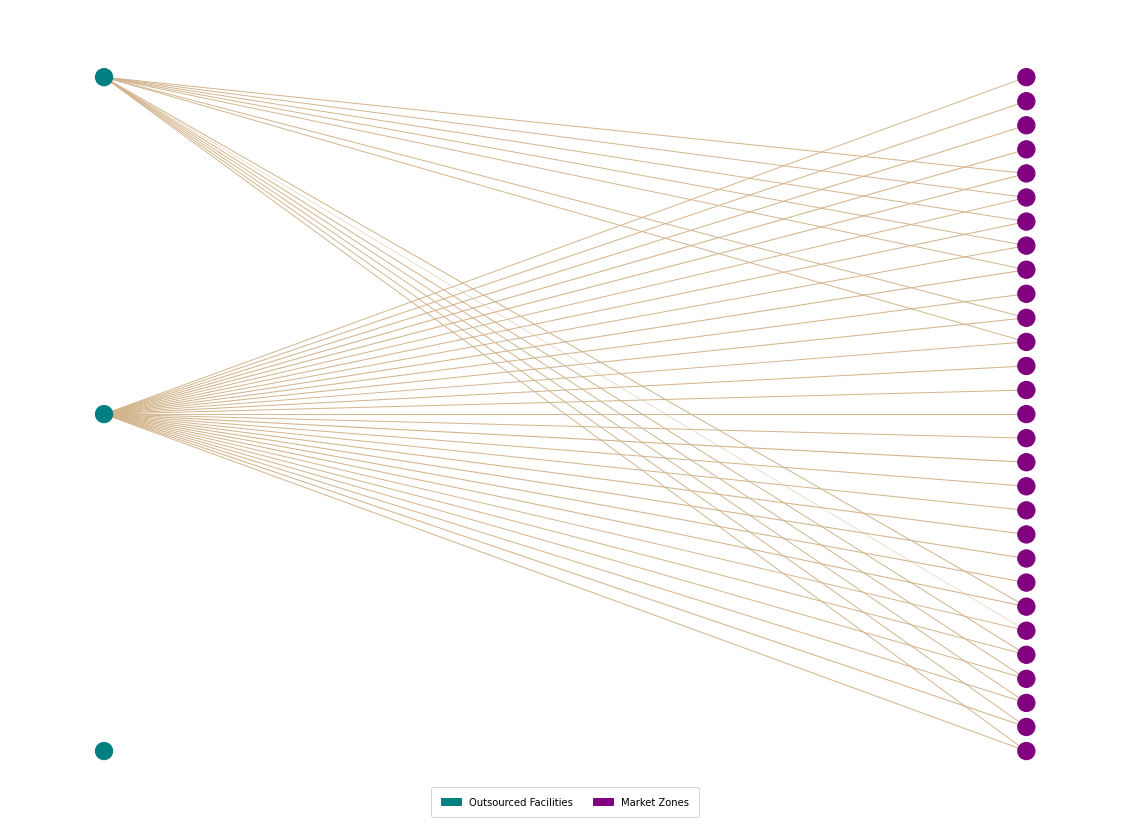

In [131]:
for index in indices:
    T1_mat = np.array(list(v_val_T_ljm.values())).reshape(num_Scenarios, Products, Outsourced, Distribution)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)
    T1 = sum(T1_mat[index])
    T2 = sum(T2_mat[index])
    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Weight = []
    Weight_lk = []
    Max_p = max(Outsourced, Market)
    O = ["L_" + str(l) for l in range(Outsourced)]
    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("L_" + str(l), "K_" + str(k)))    
    Weight_lk.extend(T2.sum(axis = 1))

    Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])
                
    Labels = []
    Graph = nx.Graph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (0, y_pos[l])
        Graph.add_node(O[l])
        Node_colors.append('teal')
        Labels.append("l" + str(l))
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(O, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (1, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('purple')
        Labels.append("k" + str(k))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))


    # Add edges
    Graph.add_edges_from(LK_edges)
    Edge_colors.extend(['tan' for l in LK_edges])

    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = False, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight)

    limits=plt.axis('off')
    plt.gcf().set_size_inches(20, 15)

    legend_o = mpatches.Patch(color = 'teal', label = 'Outsourced Facilities')
    legend_dc = mpatches.Patch(color = 'purple', label = 'Market Zones')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_o, legend_dc], ncol = 2, borderpad=1)

    plt.show()
        


In [132]:
index

56

In [96]:
r_level

0.5

In [183]:
r_level = 0.5
demand = np.loadtxt('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_2/Demand_2.txt').reshape((300, 3, 29))
text_file = open('/home/dkabe/Model_brainstorming/Input_Data/Realistic/Instance_2/scen_2.txt', "r")
ls = text_file.read().split('\n')[:-1]
Scen = list(map(lambda x: ast.literal_eval(x), ls))
f = open(path + "Instance_2/variable_vals_" +str(r_level) + ".txt", "r")
text = f.read()
f.close()
solutions_str = text.split('\n')
for i in solutions_str:
    exec(i.lstrip().rstrip())
num_Scenarios = 300


In [184]:
print(v_val_x_i)
print(v_val_x_j)


{0: -0.0, 1: 1.0, 2: 1.0, 3: -0.0, 4: 1.0, 5: 1.0}
{0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0}


In [200]:
indices = [0, 3]
for index in indices:
    print(Scen[index])

[[0, 0, 1, 1, 1, 0], (1, 0, 1, 1)]
[[1, 0, 0, 1, 0, 1], (0, 0, 0, 1)]


In [201]:
Scen[22]

[[1, 1, 0, 1, 1, 1], (0, 0, 0, 1)]

/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:87: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


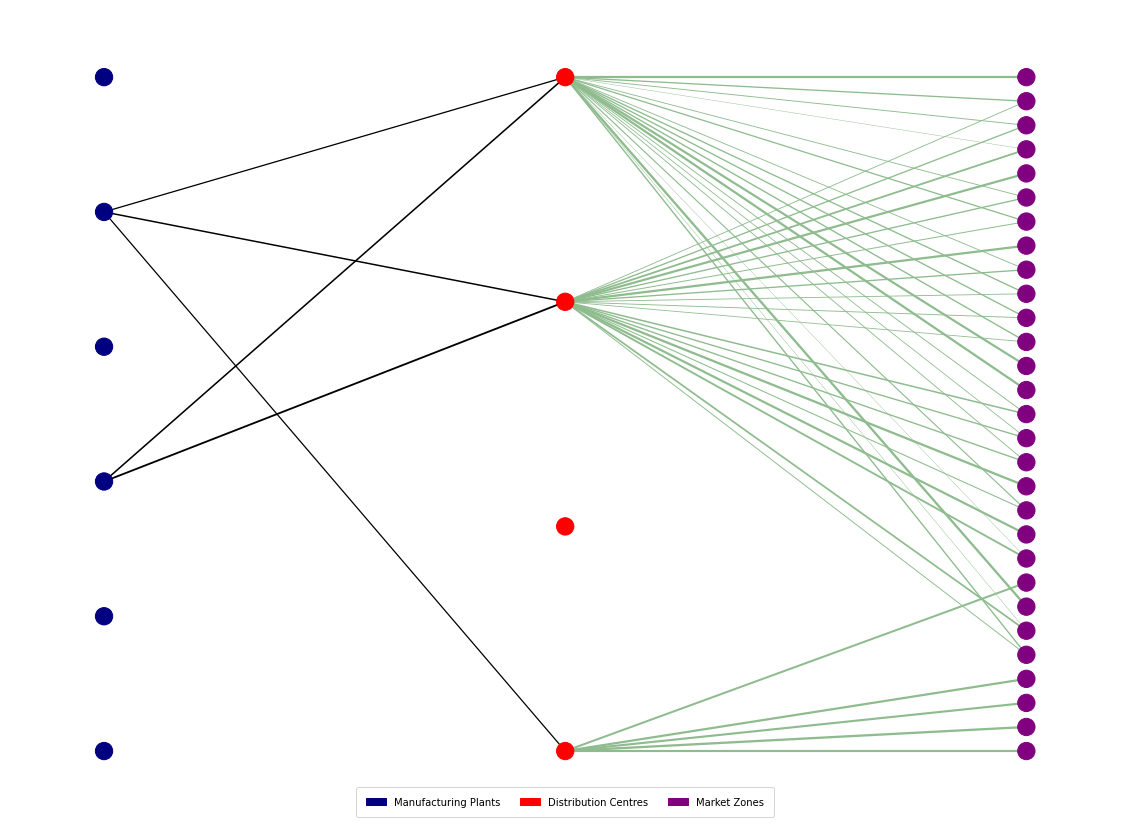

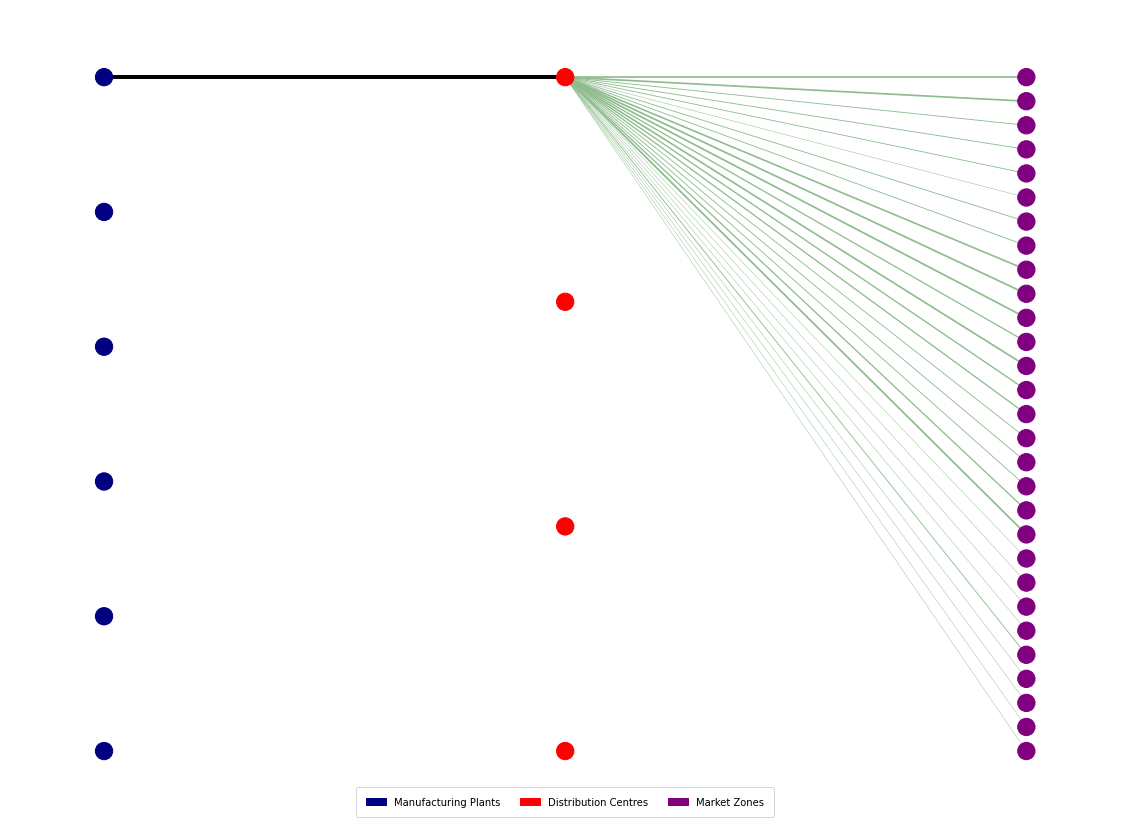

In [202]:
for index in indices:
    
    Y_mat = np.array(list(v_val_Y_ijm.values())).reshape(num_Scenarios, Products, Manufacturing_plants, Distribution)
    Z_mat = np.array(list(v_val_Z_jkm.values())).reshape(num_Scenarios, Products, Distribution, Market)
    
    Y = sum(Y_mat[index])
    Z = sum(Z_mat[index])
    
    MP = ["I_" + str(i) for i in range(Manufacturing_plants)]
    DC = ["J_" + str(j) for j in range(Distribution)]
    MZ = ["K_" + str(k) for k in range(Market)]
    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Node_size = []
    Weight = []
    Weight_ij = []
    Weight_jk = []
    Max_p = max(Manufacturing_plants, Distribution, Market)
    IJ_edges = []
    for i in range(Manufacturing_plants):
        for j in range(Distribution):
            #if Y[i][j] > 0:
            IJ_edges.append(("I_" + str(i), "J_" + str(j)))    
    Weight_ij.extend(Y.sum(axis=1))
        
    JK_edges = []
    for j in range(Distribution):
        for k in range(Market):
            #if Z[j][k] > 0:
            JK_edges.append(("J_" + str(j), "K_" + str(k)))
    Weight_jk.extend(Z.sum(axis=1))
        
    Weight.extend([4*Y[i][j]/max(Weight_ij) for i in range(Manufacturing_plants) for j in range(Distribution)])
    Weight.extend([29*Z[j][k]/max(Weight_jk) for j in range(Distribution) for k in range(Market)])
                
    Labels = []
    Graph = nx.Graph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Manufacturing_plants)
    for i in range(Manufacturing_plants):
        position = (0, y_pos[i])
        Graph.add_node(MP[i])
        Node_colors.append('navy')
        Labels.append("i" + str(i))
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(MP, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Distribution)
    for j in range(Distribution):
        position = (1, y_pos[j])
        Graph.add_node(DC[j])
        Node_colors.append('red')
        Labels.append("j" + str(j))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(DC, Position_values)))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (2, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('purple')
        Labels.append("k" + str(k))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))

    # Add Edges

    Graph.add_edges_from(IJ_edges)
    Graph.add_edges_from(JK_edges)
    Edge_colors.extend(['black' for i in IJ_edges])
    Edge_colors.extend(['darkseagreen' for i in JK_edges])

    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = False, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight)

    limits=plt.axis('off')
    plt.gcf().set_size_inches(20, 15)

    legend_mp = mpatches.Patch(color = 'navy', label = 'Manufacturing Plants')
    legend_dc = mpatches.Patch(color = 'red', label = 'Distribution Centres')
    legend_mz = mpatches.Patch(color = 'purple', label = 'Market Zones')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_mp, legend_dc, legend_mz], ncol = 3, borderpad=1)

    plt.show()

/home/dkabe/env_gurobi/lib/python3.7/site-packages/ipykernel_launcher.py:64: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


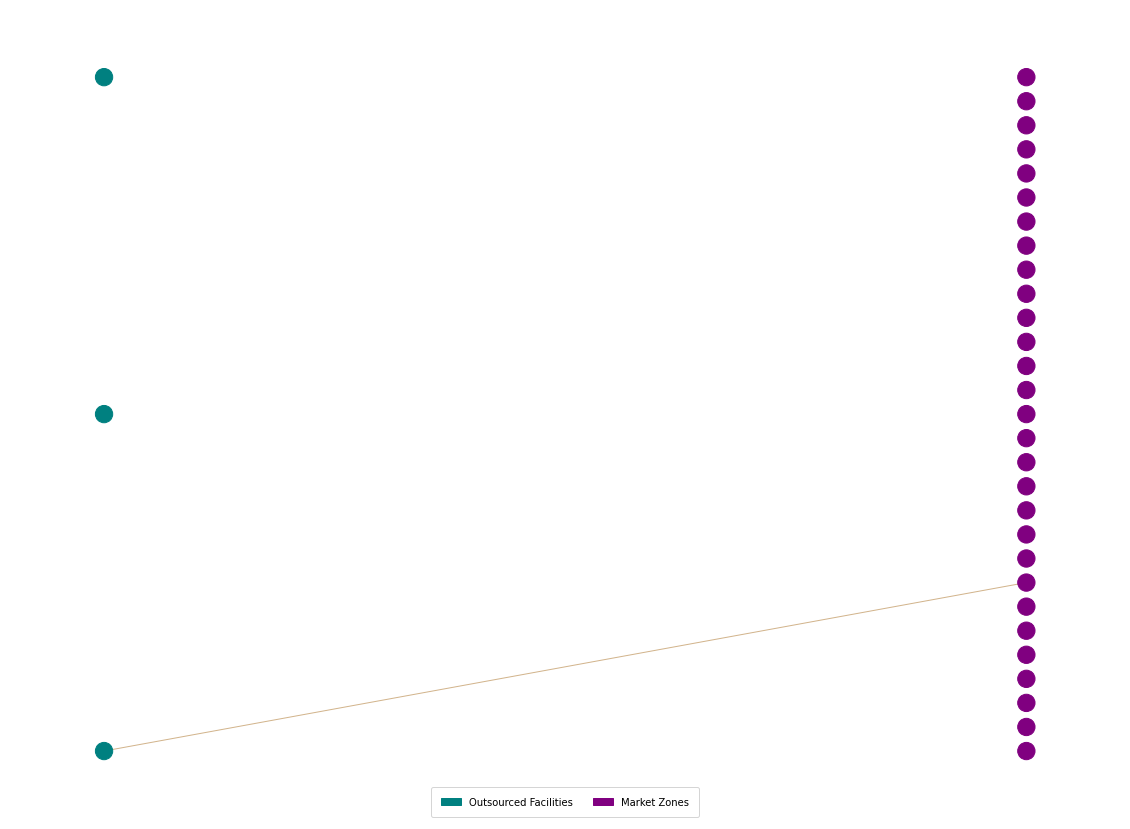

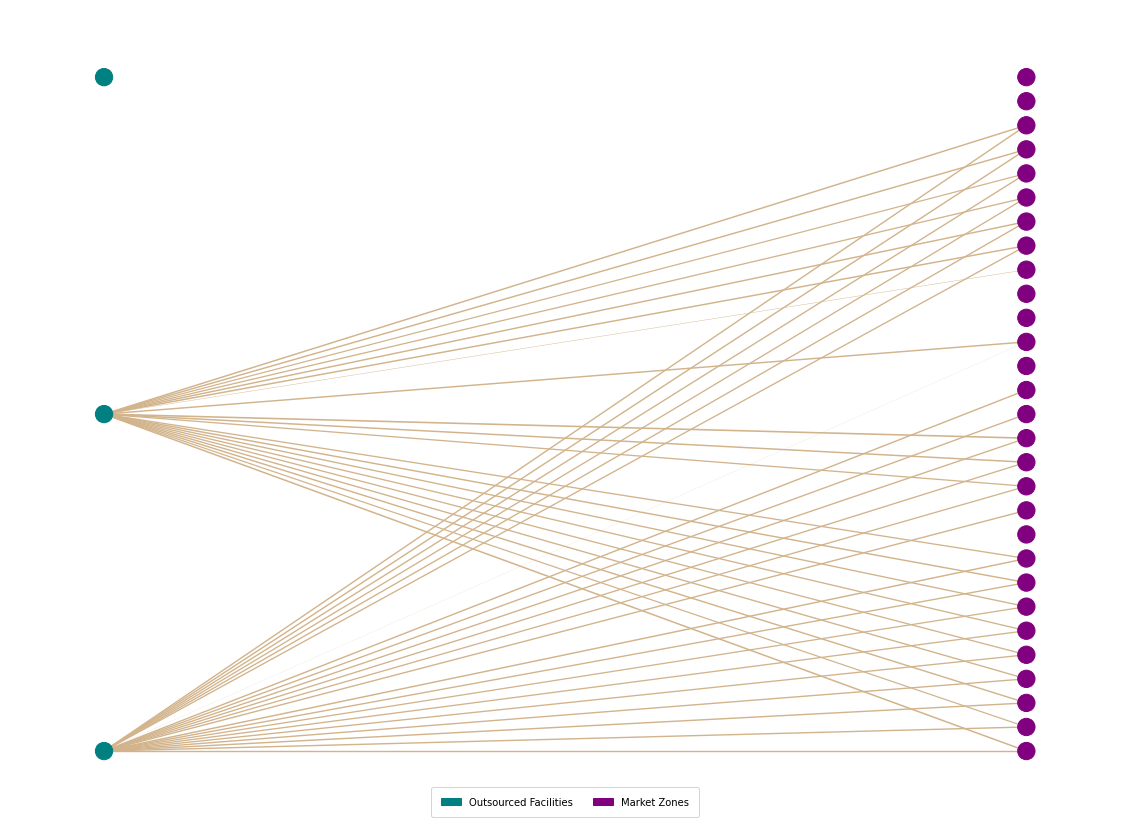

In [207]:
for index in indices:
    T1_mat = np.array(list(v_val_T_ljm.values())).reshape(num_Scenarios, Products, Outsourced, Distribution)
    T2_mat = np.array(list(v_val_T_lkm.values())).reshape(num_Scenarios, Products, Outsourced, Market)
    T1 = sum(T1_mat[index])
    T2 = sum(T2_mat[index])
    Position_dic = {}
    Node_colors = []
    Edge_colors = []
    Weight = []
    Weight_lk = []
    Max_p = max(Outsourced, Market)
    O = ["L_" + str(l) for l in range(Outsourced)]
    LK_edges = []
    for l in range(Outsourced):
        for k in range(Market):
            #if Tlk[l][k] > 0:
            LK_edges.append(("L_" + str(l), "K_" + str(k)))    
    Weight_lk.extend(T2.sum(axis = 1))

    for l in range(Outsourced):
        for k in range(Market):
            if T2[l][k]/max(Weight_lk) < 1:
                Weight.append(29*T2[l][k]/max(Weight_lk))
            else:
                Weight.append(T2[l][k]/max(Weight_lk))
    #Weight.extend([29*T2[l][k]/max(Weight_lk) for l in range(Outsourced) for k in range(Market)])
    Labels = []
    Graph = nx.Graph()

    Position_values = []
    y_pos = np.linspace(0, Max_p, Outsourced)
    for l in range(Outsourced):
        position = (0, y_pos[l])
        Graph.add_node(O[l])
        Node_colors.append('teal')
        Labels.append("l" + str(l))
        Position_values.append(np.asarray(position))
    Position_dic = dict(zip(O, Position_values))

    Position_values = []
    y_pos = np.linspace(0, Max_p, Market)
    for k in range(Market):
        position = (1, y_pos[k])
        Graph.add_node(MZ[k])
        Node_colors.append('purple')
        Labels.append("k" + str(k))
        Position_values.append(np.asarray(position))
    Position_dic.update(dict(zip(MZ, Position_values)))


    # Add edges
    Graph.add_edges_from(LK_edges)
    Edge_colors.extend(['tan' for l in LK_edges])

    nodePos = nx.shell_layout(Graph)
    nx.draw_networkx(Graph, with_labels = False, node_color = Node_colors, edge_color = Edge_colors, pos = Position_dic, width = Weight)

    limits=plt.axis('off')
    plt.gcf().set_size_inches(20, 15)

    legend_o = mpatches.Patch(color = 'teal', label = 'Outsourced Facilities')
    legend_dc = mpatches.Patch(color = 'purple', label = 'Market Zones')

    ax = plt.subplot(111)
    ax.legend(loc = 'lower center', handles=[legend_o, legend_dc], ncol = 2, borderpad=1)

    plt.show()